# 2.3.1 Korteweg--de Vries (KdV) Equation

Shen--Tang--Wang (STW):
```
The KdV equation is a celebrated mathematical model of waves on shallow water
surfaces. A fascinating property of the KdV equation is that it admits soliton-type
solutions (cf. Zabusky and Galvin (1971)).
```

The KdV equations on $\mathbb{R}$ and given by

$$
\begin{aligned}
&\partial_t u + u \partial_y u + \partial_y^3 u = 0, \ y \in (-\infty, \infty), \ t > 0 \\
&u(y,0) = u_0(y), \ y \in (-\infty, \infty)
\end{aligned}
$$

This equation has the exact solution

$$
\begin{aligned}
u(y,t) = 12 \kappa^2 \operatorname{sech}^2(\kappa (y - y_0) - 4\kappa^3 t)
\end{aligned}
$$

here $y_0$ is the center of the initial profile $u(y,0)$, and $\kappa$ is a constant related to the
traveling phase speed.

Following STW, we will demonstrate solving this equaiton using Fourier spectral methods.

Outline of process.

1. Convert infinite domain to fundamental periodic domain.
2. Apply Fourier transform and integrating factor create and ODE which is nice of ODE solvers.
3. Solve this ODE with python tools such as scipy ODE integrators, diy RK4, and pydiffeq (wrapper on DifferentialEquation.jl)

## Convert inifinite domain to fundamental periodic domain

Accepting the decay suggested by STW, we have that $u(y,t) \to 0$ as $|y| \to \infty$ for all t > 0 exponentially. Thus we can use periodic boundary conditions on some large interval $(-\pi L, \pi L)$ (because it's zero both end-points). Moreover, we can through the change of variable and the chain rule remove the $L$ parameter from the domain and place it in the equations. (This process is similar to non-dimensionalization for say Navier--Stokes).
The change of variables from $y \in [-\pi L, \pi L]$ to $x \in [0, 2 \pi]$ is given by
$$
\begin{aligned}
&x = \frac{y}{L} + \pi, \ y = L(x - \pi) \\
&v(x,t) = u(y,t), \ v_0(x) = u_0(y).
\end{aligned}
$$
Via the chain rule the resulting intial boundary value is
$$
\begin{aligned}
&\partial_t v + \frac{1}{L} v \partial_x v + \frac{1}{L^3} \partial_x^3 v = 0, \ x \in (0, 2\pi), \ t > 0 \\
&v(x,0) = v_0(x), \ y \in [0, 2\pi] \\
&v(\cdot, t) \ \text{periodic on} \ [0, 2 \pi), \ t \geq 0
\end{aligned}
$$

To make this more concrete let's plot some initial conditions in $u$ and $v$. Following STW, an initial condition with the superposition of soliton 5 solitons (solitary waves)
can be written as
$$
\begin{aligned}
u_0(y) = \sum_{j=1}^5 12 \kappa^2_j \operatorname{sech}^2 (\kappa_j (y - y_j)).
\end{aligned}
$$
Noting that we have fixed the typo in STW equation 2.62 where $y_0$ should read $y_j$. In the following code we build a $k$ soliton superposition and plot it for $k=5$.

In [193]:
# Example KdV code
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from matplotlib.figure import Figure

L = 50.0
N = 512
_scales_STW = np.array([0.3, 0.25, 0.2, 0.15, 0.1])
_shifts_STW = np.array([-120.0, -90.0, -60.0, -30.0, 0.0])

def domain(L: float, N: int)-> np.ndarray:
    #return np.linspace(-L*np.pi, L*np.pi, N)
    return (L*2*np.pi/N)*np.arange(-N/2,N/2)

def k_soliton_superposition(y: np.ndarray, shifts: np.ndarray, scales: np.ndarray)->np.ndarray:
    return np.sum(np.array([12.0*scale**2.0/(np.cosh(scale*(y-shift)))**2.0 for shift, scale in zip(shifts, scales)]), axis=0)

def to_x_coords(y: np.ndarray, L: float)->np.ndarray:
    return ((1/L)*y + np.pi)

def to_y_coords(x: np.ndarray, L: float)->np.ndarray:
    return L*(x - np.pi)

def kdv_rhs(t: float, u_tilde: np.ndarray, L: float, N: int)->np.ndarray:
    """
    Compute the RHS of a (Fourier) spectral ODE for the KdV equation.
    """
    # freqency vector
    # k_vec = np.fft.fftfreq(len(u_tilde))
    k_vec = np.concatenate((np.arange(N/2) , np.array([0]) , np.arange(-N/2+1,0)))
    # integrating factor
    g_vec = np.exp(-1j*k_vec**3*t/L**3)
    return -1j/(2*L)*g_vec*np.fft.fft((np.real(np.fft.ifft(u_tilde/g_vec)))**2)

def integrate_kdv_stw_2_3_1(u_tilde_0: np.ndarray, L: float, N: int, t_final: float, t_step: float)->tuple[np.ndarray, np.ndarray]:
    """
    Compute the solution for the (Fourier) spectral ODE using scipy.integrate.solve_ivp
    """
    f = lambda t, y: kdv_rhs(t=t, u_tilde=y, L=L, N=N)
    t_mesh = np.arange(start=0.0, stop=t_final, step=t_step)
    return solve_ivp(fun=f, t_span=[t_mesh[0], t_mesh[-1]], t_eval=t_mesh, y0=u_tilde_0, max_step=0.01)


def plot_ic(y: np.ndarray, u_0: np.ndarray)->Figure:
    """
    Plot the initial condition (IC) in both the physical and spectral domain

    Spectral plotting adapted from scipy documentation:
    https://docs.scipy.org/doc/scipy/tutorial/fft.html
    """
    # Plot the physical domain
    fig, axs = plt.subplots(2, 1, figsize=(10, 8))
    axs[0].plot(y, u_0)
    axs[0].set_title('Signal')
    axs[0].set_xlabel('x')
    axs[0].set_ylabel('Amplitude')
    
    # Generate and plot the frequency domain
    freqs = np.fft.fftfreq(len(u_0), y[1]-y[0])[:len(u_0)//2]
    fft_out = np.fft.fft(u_0)
    axs[1].plot(freqs, 2.0/len(u_0)*np.abs(fft_out[0:len(u_0)//2]))
    axs[1].set_title('FFT')
    axs[1].set_xlabel('Frequency (Hz)')
    axs[1].set_ylabel('Magnitude')
    return fig, axs

def plot_solution(Y: np.ndarray, T: np.ndarray, U: np.ndarray)->Figure:
    """
    Plot 3d solution of KdV with contours.

    Adapted from: 
    https://matplotlib.org/stable/gallery/mplot3d/contour3d_3.html#sphx-glr-gallery-mplot3d-contour3d-3-py
    """
    ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')    
    ax.plot_surface(Y, T, U, edgecolor='royalblue', lw=0.5, rstride=8, cstride=8, alpha=0.10)
    ax.contour(Y, T, U, zdir='z', offset=-1, cmap='coolwarm')
    ax.contour(Y, T, U, zdir='x', offset=-200, cmap='coolwarm')
    ax.contour(Y, T, U, zdir='y', offset=75, cmap='coolwarm')

    ax.set(xlim=(-200, 150), ylim=(-25.0, 75.0), zlim=(-1.0, 1.0),
       xlabel='y', ylabel='t', zlabel='u')
    return ax




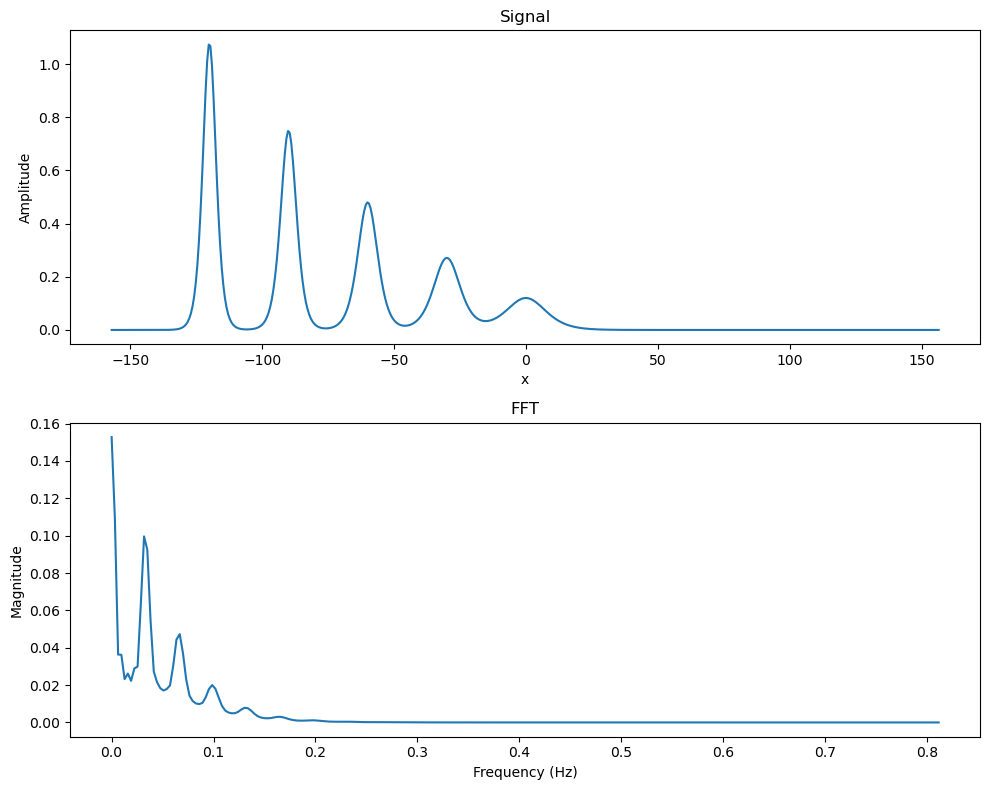

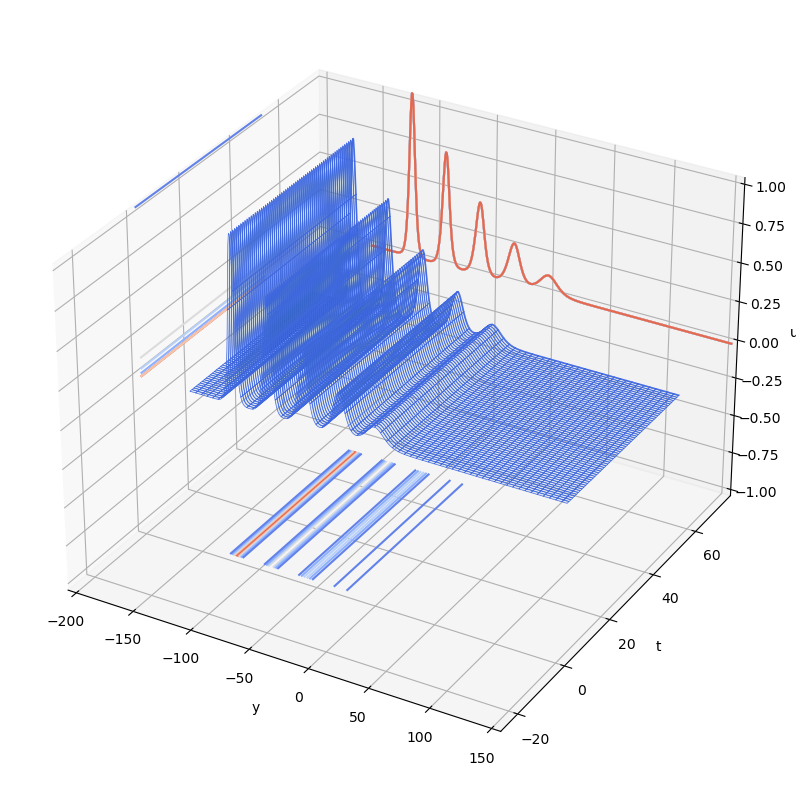

[ 0.00000000e+00-1.72466716e-01j -1.01701533e-01-1.62633314e-02j
 -2.55614273e-02+6.91852146e-03j -1.94151256e-02+7.20235856e-03j
 -2.53643523e-02+2.40457486e-02j  5.40682059e-03+3.19384347e-02j
  1.76125486e-02+1.71051931e-02j  7.69399250e-03+7.38029061e-03j
  1.87927199e-02-1.74408762e-02j  4.57736949e-02-4.50248337e-02j
 -5.73637553e-02-7.30334145e-02j -5.77798398e-02+5.35708200e-02j
 -7.28108131e-03+3.98805613e-02j  4.36416042e-03+2.24524224e-03j
  2.96313371e-02-6.47222394e-03j -1.13752844e-02-1.66041971e-02j
 -3.66669464e-03+3.42587840e-04j -8.43935475e-03-3.73863644e-03j
  1.58363358e-02-8.65786432e-03j  7.11383659e-03-3.36138678e-02j
 -3.93615483e-02+1.02323867e-02j  3.49601452e-02+2.60832250e-02j
  2.90029206e-02-2.62857169e-02j  2.13226129e-02+5.13777126e-03j
  4.66906530e-03-2.04150137e-03j -7.35064178e-03-8.62170443e-03j
  3.74568602e-03+4.12317563e-03j  8.58705321e-03-2.62314902e-03j
  1.07387974e-02-7.38180420e-04j -9.30892249e-03-5.58988994e-03j
  1.82405446e-04+9.290797

In [194]:
# test functions

def test_k_soliton_superposition():
    superposition_of_5 = k_soliton_superposition(y=domain(L=50.0, N=512), shifts=_shifts_STW, scales=_scales_STW)
    assert len(superposition_of_5) == 512

def test_plot_ic():
    y = domain(L=50.0, N=512)
    superposition_of_5 = k_soliton_superposition(y=y, shifts=_shifts_STW, scales=_scales_STW)
    fig, axs = plot_ic(y=y, u_0 = superposition_of_5)
    plt.tight_layout()
    plt.show()

def test_plot_solution():
    y = domain(L=50, N=512)
    t_step = 0.1
    t_final = 50
    t = np.arange(start=0.0, stop=t_final, step=t_step)
    Y, T = np.meshgrid(y, t, indexing='xy')
    superposition_of_5 = k_soliton_superposition(y=y, shifts=_shifts_STW, scales=_scales_STW)
    Z = np.array([superposition_of_5 for _ in t])
    fig = plot_solution(Y=Y, T=T, U=Z)
    plt.show()

def test_kdv_rhs():
    y = domain(L=50.0, N=512)
    superposition_of_5 = k_soliton_superposition(y=y, shifts=_shifts_STW, scales=_scales_STW)
    t = 0.0
    u_tilde = np.fft.fft(superposition_of_5)
    spectral_rhs = kdv_rhs(t=t, u_tilde=u_tilde, L=L, N=N)
    print(spectral_rhs)

def test_integrate_kdv_stw_2_3_1():
    y = domain(L=50.0, N=512)
    superposition_of_5 = k_soliton_superposition(y=y, shifts=_shifts_STW, scales=_scales_STW)
    t_step = 0.01
    u_tilde_0 = np.fft.fft(superposition_of_5)
    kdv_solution = integrate_kdv_stw_2_3_1(u_tilde_0=u_tilde_0, L=L, N=N, t_final=600.0, t_step=t_step)
    print(kdv_solution)
    return y, kdv_solution

test_k_soliton_superposition()
test_plot_ic()
test_plot_solution()
test_kdv_rhs()
y, kdv_solution = test_integrate_kdv_stw_2_3_1()

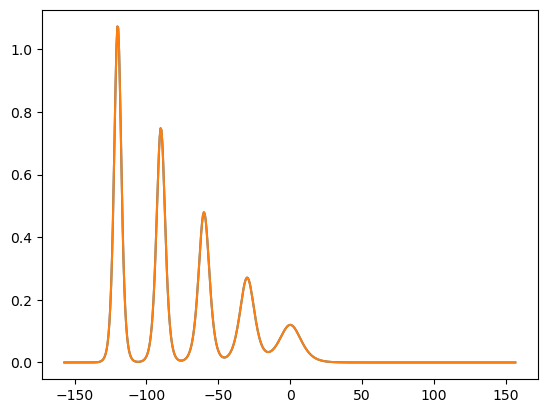

In [196]:
# kdv solution
plt.plot(y, np.real(np.fft.ifft(kdv_solution.y[:,0])))
plt.plot(y, np.real(np.fft.ifft(kdv_solution.y[:,-1])))
plt.show()

In [183]:
kdv_solution

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 360002
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.0000e+00, 1.0000e-02, 2.0000e-02, ..., 5.9997e+02, 5.9998e+02,
       5.9999e+02])
 t_events: None
        y: array([[ 39.03752444+0.00000000e+00j,  39.03752444-1.72129867e-03j,
         39.03752444-3.44259734e-03j, ...,  39.03752444-1.03272756e+02j,
         39.03752444-1.03274478e+02j,  39.03752444-1.03276199e+02j],
       [ -0.54407074-2.79446295e+01j,  -0.54540806-2.79451538e+01j,
         -0.54674536-2.79456781e+01j, ..., -44.71606233-6.73713184e+01j,
        -44.71650808-6.73720491e+01j, -44.71695381-6.73727798e+01j],
       [ -7.62305168-5.38578041e+00j,  -7.62383956-5.38530609e+00j,
         -7.62462748-5.38483185e+00j, ..., -32.08842847-8.86504574e+00j,
        -32.08841559-8.86515248e+00j, -32.08840271-8.86525921e+00j],
       ...,
       [ -8.42133143+3.83669699e+00j,  -8.42104417+3.8372

In [175]:
kdv_solution

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 360002
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.0000e+00, 1.0000e-02, 2.0000e-02, ..., 5.9997e+02, 5.9998e+02,
       5.9999e+02])
 t_events: None
        y: array([[ 39.03752444+0.00000000e+00j,  39.03752444-1.72129867e-03j,
         39.03752444-3.44259734e-03j, ...,  39.03752444-1.03272756e+02j,
         39.03752444-1.03274478e+02j,  39.03752444-1.03276199e+02j],
       [ -0.54407074-2.79446295e+01j,  -0.54540808-2.79451538e+01j,
         -0.54674541-2.79456780e+01j, ..., -80.78018391-5.93984324e+01j,
        -80.78152125-5.93989566e+01j, -80.78285858-5.93994809e+01j],
       [ -7.62305168-5.38578041e+00j,  -7.62383955-5.38530605e+00j,
         -7.62462743-5.38483169e+00j, ..., -54.89311958+2.30744303e+01j,
        -54.89390746+2.30749047e+01j, -54.89469533+2.30753790e+01j],
       ...,
       [ -8.42133143+3.83669699e+00j,  -8.42104421+3.8372